In [678]:
import os 
import numpy as np
import pandas as pd
from tqdm import tqdm
import json

import geopandas as gpd
import rasterio as rio
import geopy.distance
import shapely
from shapely.geometry import Point
from shapely.geometry import Polygon

from geog import propagate

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap

In [679]:
MAX_POP = 10000
PROJ_CRS = 3857
CUR_CITY = 'montréal'

In [680]:
def get_poly_tile(row):
    x, y = row['geometry'].x, row['geometry'].y
    offset = 1 / 240  # 0.004166666666666667
    L = [(x+offset,y+offset), (x-offset,y+offset), (x-offset,y-offset), (x+offset,y-offset), (x+offset,y+offset)]
    return Polygon(L)

In [681]:
coords_gdf = gpd.read_file(f'../data/pop_tiles/{CUR_CITY}_coords.gpkg')
city_center = coords_gdf[coords_gdf['is_center']].geometry.iloc[0]

p = [city_center.x, city_center.y]
n_points = 5
d = 50000 # meters
angles = np.linspace(0, 360, n_points)
edge_points = propagate(p, angles, d)[:-1]  # Order is: E, N, W, S

edge_points = [Point((point[0], point[1])) for point in edge_points]
edge_points = gpd.GeoSeries(edge_points, crs=4326).to_crs(PROJ_CRS).to_list()

# E_point, N_point, W_point, S_point = edge_points[0], edge_points[1], edge_points[2], edge_points[3]

In [682]:
# coords_gdf = gpd.read_file(f'../data/pop_tiles/{CUR_CITY}_coords.gpkg')
# coords_gdf = coords_gdf.to_crs(PROJ_CRS)
# # Use coords center point to obtain boundaries for plot
# row_center_idx, col_center_idx = coords_gdf[coords_gdf['is_center'] == True][['row_idx', 'col_idx']].values[0]

# row_center, col_center = coords_gdf[coords_gdf['row_idx'] == row_center_idx], coords_gdf[coords_gdf['col_idx'] == col_center_idx]

# W_point = row_center.iloc[row_center['col_idx'].argmin()]
# E_point = row_center.iloc[row_center['col_idx'].argmax()]

# N_point = col_center.iloc[col_center['row_idx'].argmin()]
# S_point = col_center.iloc[col_center['row_idx'].argmax()]

In [683]:
coords_gdf = gpd.read_file(f'../data/pop_tiles/{CUR_CITY}_coords.gpkg')
coords_gdf['geometry'] = coords_gdf.apply(lambda x: get_poly_tile(x), axis=1)
coords_gdf['pop_count'] = np.where(coords_gdf['pop_count'] > MAX_POP, [MAX_POP], coords_gdf['pop_count'])
coords_gdf = coords_gdf.to_crs(PROJ_CRS)
# coords_gdf

In [684]:
rails_gdf = gpd.read_file(f'../data/osm_data/{CUR_CITY}_rail_osm.geojson')
rails_gdf = rails_gdf.to_crs(PROJ_CRS)

In [685]:
stations_gdf = gpd.read_file(f'../data/osm_data/{CUR_CITY}_station_osm.geojson')
stations_gdf = stations_gdf.to_crs(PROJ_CRS)

In [686]:
water_gdf = gpd.read_file(f'../data/city_water/{CUR_CITY}_water.gpkg')
water_gdf = water_gdf.to_crs(PROJ_CRS)

In [687]:
colors = np.array([(255, 255, 255), (241, 197, 0), (220, 70, 51)]) / 255
colour_map = LinearSegmentedColormap.from_list("soc", colors, N=100)  # https://matplotlib.org/stable/gallery/color/custom_cmap.html

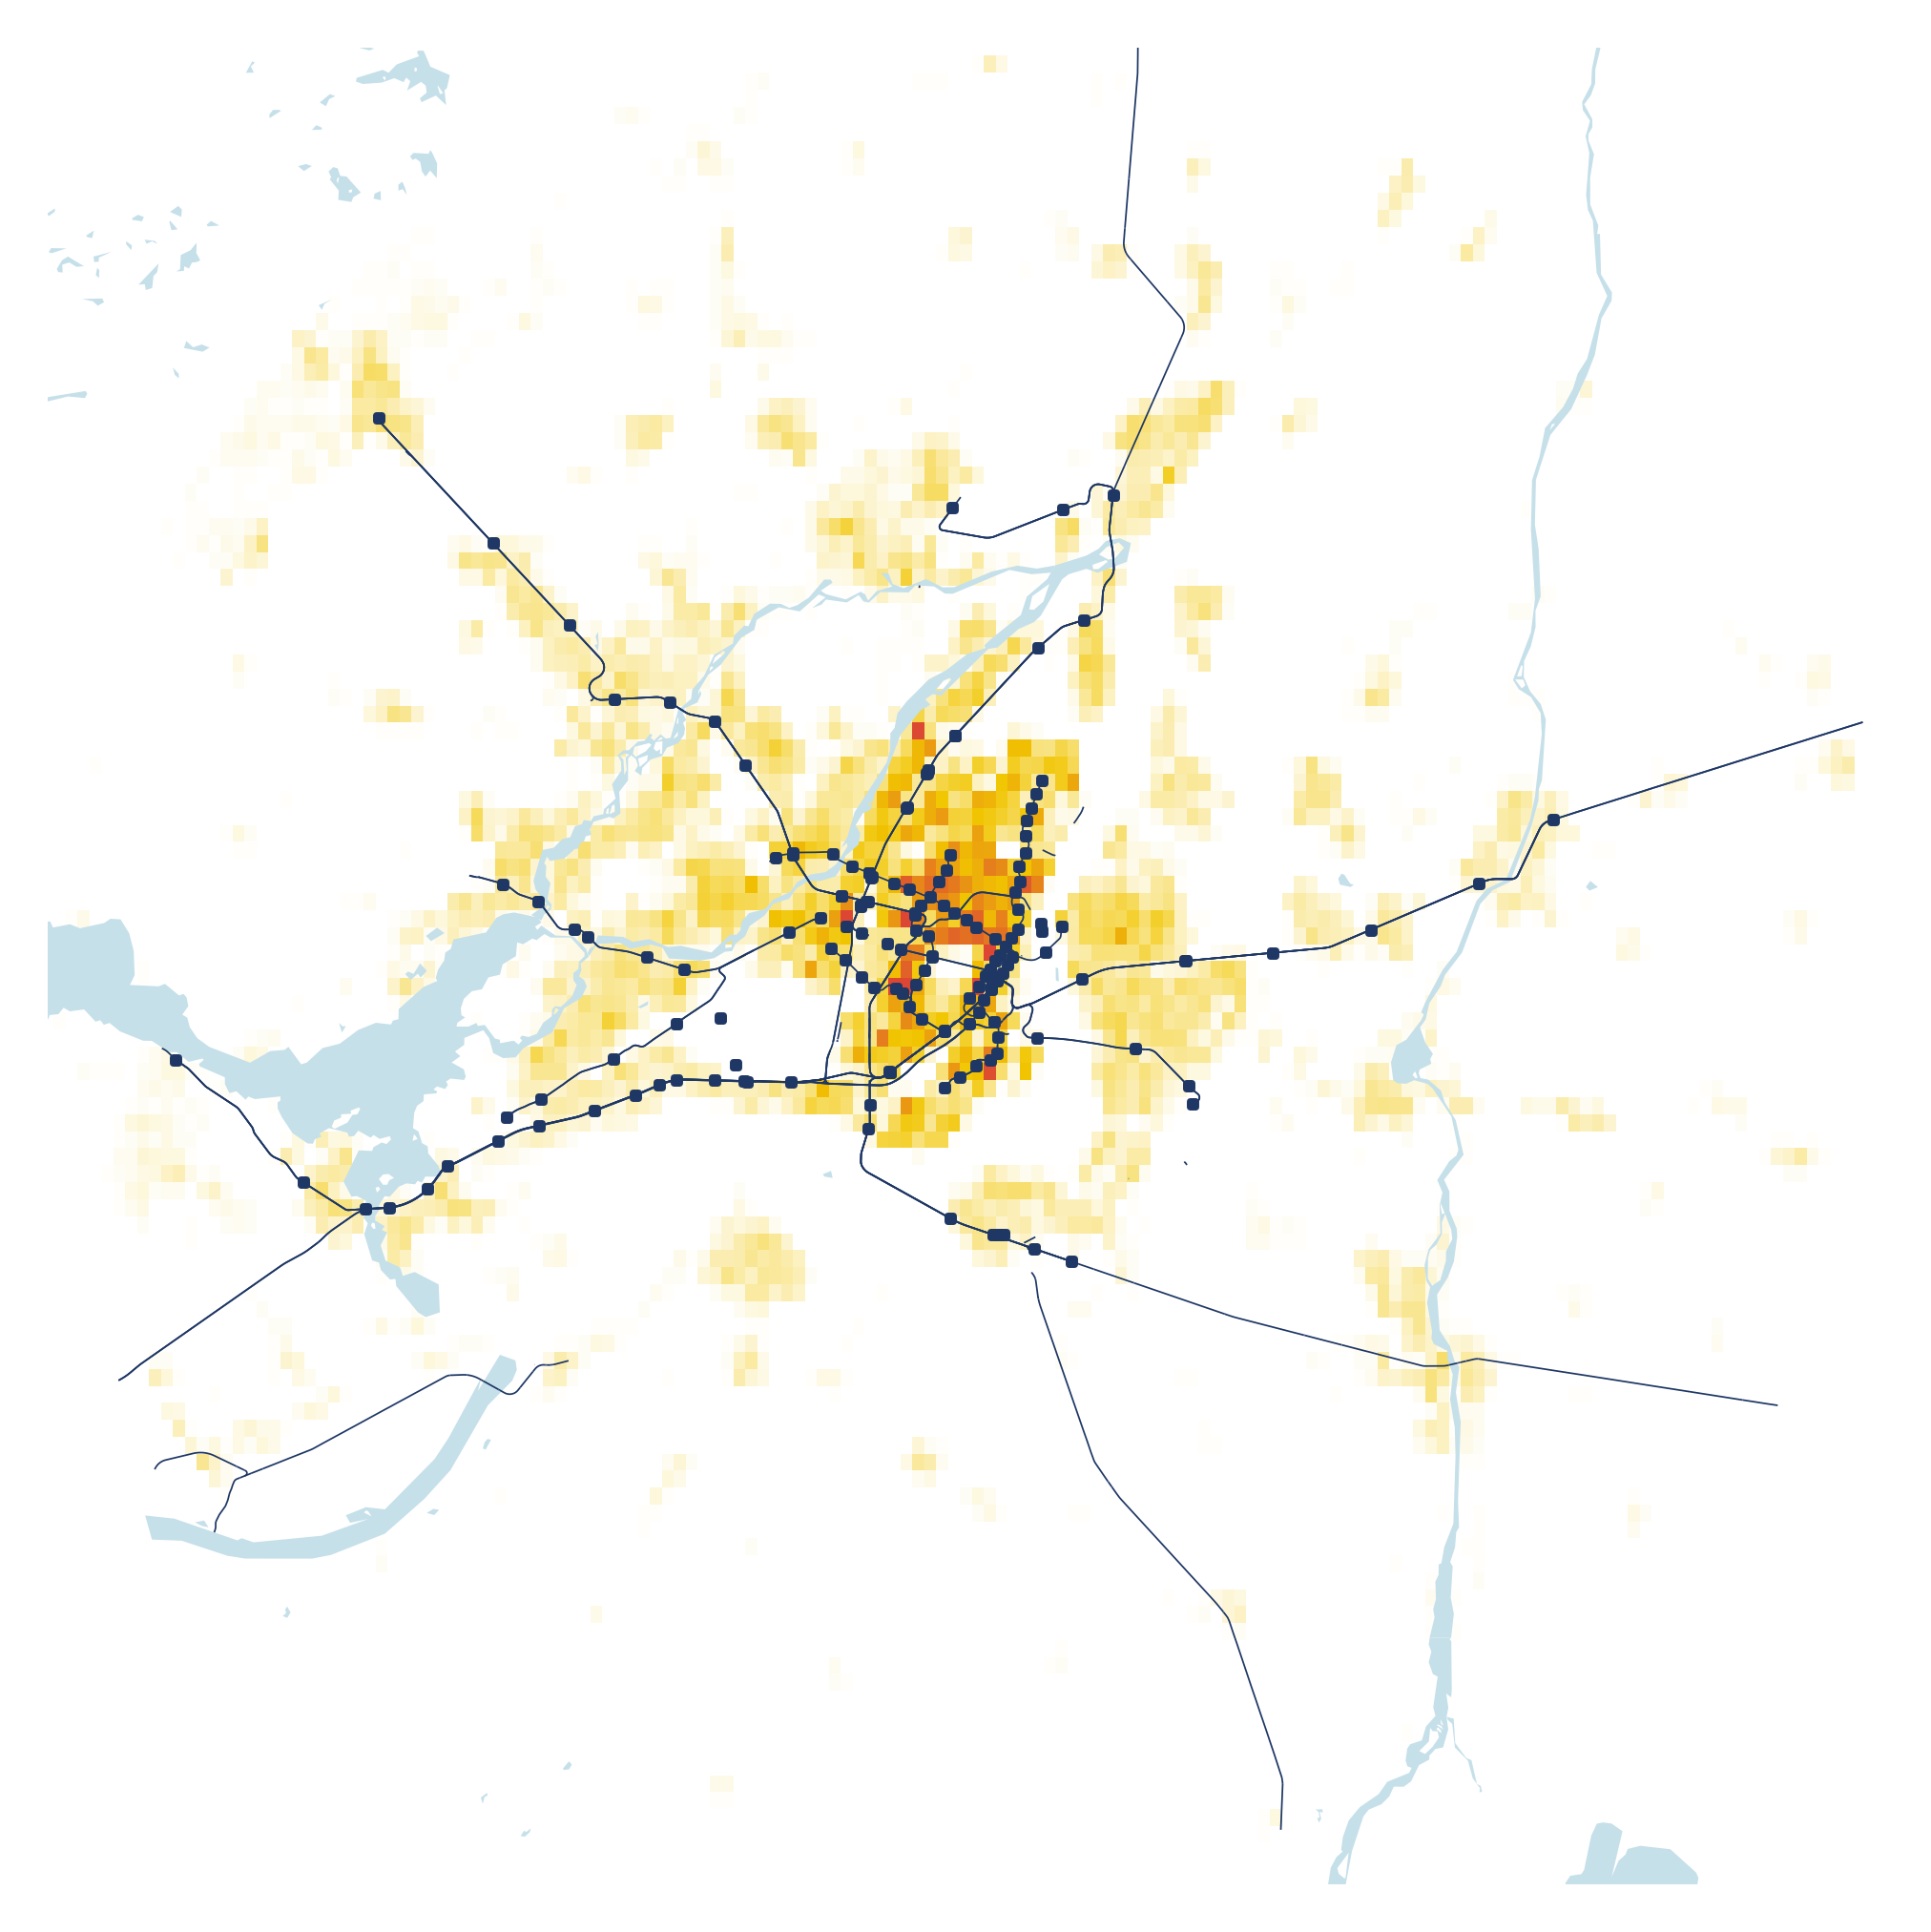

In [688]:
# Try to find a ratio that works for ~400 or 500 DPI
fig, ax = plt.subplots(figsize=(5, 5), dpi=500)  # ~350 pixels
base = coords_gdf.plot(
    ax=ax,
    column="pop_count",
    cmap=colour_map,
    missing_kwds={'color': 'white'},
);

base = water_gdf.plot(ax=base, color='#c6e0ea');
base = rails_gdf.plot(ax=base, color='#1e3765', lw=0.25, markersize=0.75);  # TODO: Filter for lines
base = stations_gdf.plot(ax=base, marker='s', color='#1e3765', markersize=0.75);  # what's going on with the markers?

# limit = 0

# ax.set_xlim(W_point['geometry'].x + limit, E_point['geometry'].x - limit)
# ax.set_ylim(S_point['geometry'].y + limit, N_point['geometry'].y - limit)
# ax.margins(0,0)

# edge_points is in the order [E, N, W, S]
ax.set_xlim(edge_points[2].x, edge_points[0].x)  # W <--> E
ax.set_ylim(edge_points[3].y, edge_points[1].y)  # S <--> N
ax.margins(0,0)

ax.set_axis_off();

plt.savefig(f'../data/city_image/{CUR_CITY}.png')

# Clip circle: https://matplotlib.org/stable/gallery/images_contours_and_fields/image_clip_path.html
# but also can just do HTML/CSS circle!!